In [46]:
import boto3
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import sys
# data visualization package
import matplotlib.pyplot as plt

# ignore the warning
import warnings
# for evaluation metric
# accuracy
from sklearn.metrics import accuracy_score
# Report
from sklearn.metrics import classification_report
# AUC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pylab import rcParams

# for model comparision
from sklearn import metrics

In [2]:
client = boto3.client(
    's3',
    aws_access_key_id='',
    aws_secret_access_key=''
)

## Loading Files from S3

In [4]:
## Load the session training features  
bucket_name = 'msds630projbucket' # Add your bucket name
file_name = 'train_val/train_session_features.csv'
s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)
obj = bucket.Object(key=file_name)  # S3 uses key-value structure wherekey is your file name 
file_content = obj.get()["Body"].read().decode('utf-8')  # Read the Body which is the contents of the file.
if sys.version_info[0] < 3: 
    from StringIO import StringIO # Python 2.x
else:
    from io import StringIO # Python 3.x
# read data into pandas dataframe
df_session_train_features = pd.read_csv(StringIO(file_content))

In [7]:
df_session_train_features.head(4)

,user_id_hash,is_session,previous_sessions_duration,is_user_first_session,session_index,os_name_encoding_7,os_name_encoding_14,user_id_hash.1,timezone_encoding_7,timezone_encoding_14,country_encoding_7,country_encoding_14
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,1.000000,7.129631e+06,1,22,0.043905,0.043905,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,0.000736,0.000736,0.003497,0.003497
1,000062e9be78f3da274fec338e78f89d12000e781967f2...,0.931034,1.026536e+07,1,27,0.054341,0.054341,000062e9be78f3da274fec338e78f89d12000e781967f2...,0.008479,0.008479,0.064337,0.064337
2,00006ad44c0d33a2a526caf75514643639b7b7070dfffd...,0.777778,4.552652e+06,1,7,0.054341,0.054341,00006ad44c0d33a2a526caf75514643639b7b7070dfffd...,0.001011,0.001011,0.001214,0.001214
3,0000c5de50d243cc39f6ac4268d7511705585ca3f2a20f...,1.000000,8.027227e+05,1,3,0.054341,0.054341,0000c5de50d243cc39f6ac4268d7511705585ca3f2a20f...,0.003958,0.003958,0.064337,0.064337


In [18]:
## Load the  training  target 
bucket_name = 'msds630projbucket' # Add your bucket name
file_name = 'train_val/train_target.csv'
s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)
obj = bucket.Object(key=file_name)  # S3 uses key-value structure wherekey is your file name 
file_content = obj.get()["Body"].read().decode('utf-8')  # Read the Body which is the contents of the file.
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO # Python 2.x
else:
    from io import StringIO # Python 3.x
# read data into pandas dataframe
df_train_target = pd.read_csv(StringIO(file_content))

In [20]:
df_train_target.head(4)

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days
0,9943447915df3a45fd6720a026af905b6da6b56a37701b...,0,0
1,4e6bc35cf7fd79a5312047651e7865915f4a6bec193cf2...,0,0
2,bcfb7c8c0e926b7b6227b5b866b1cd82f1a7d09c6ea669...,0,0
3,a9d73e6928310527462fb3181a968853d1388770fc9152...,0,0


In [6]:
##  Load the session validation features  
bucket_name = 'msds630projbucket' # Add your bucket name
file_name = 'train_val/val_session_features.csv'
s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)
obj = bucket.Object(key=file_name)  # S3 uses key-value structure wherekey is your file name 
file_content = obj.get()["Body"].read().decode('utf-8')  # Read the Body which is the contents of the file.
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO # Python 2.x
else:
    from io import StringIO # Python 3.x
# read data into pandas dataframe
df_session_val_features = pd.read_csv(StringIO(file_content))

In [8]:
df_session_val_features.head(4)

,user_id_hash,is_session,previous_sessions_duration,is_user_first_session,session_index,os_name_encoding_7,os_name_encoding_14,user_id_hash.1,timezone_encoding_7,timezone_encoding_14,country_encoding_7,country_encoding_14
0,000059859ec188af6035870faf885c3038cedda05b3a54...,0.833333,5.113220e+06,1,10,0.062538,0.062538,000059859ec188af6035870faf885c3038cedda05b3a54...,0.007943,0.007943,0.077159,0.077159
1,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,0.750000,6.851255e+05,1,3,0.062538,0.062538,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,0.035739,0.035739,0.077159,0.077159
2,0000a464ad921c3288e73a3a788b5f113cabf84251a74b...,1.000000,5.369820e+05,1,2,0.052296,0.052296,0000a464ad921c3288e73a3a788b5f113cabf84251a74b...,0.007943,0.007943,0.077159,0.077159
3,0000bc4e8bfc829d327fa69bdc426dd8a789c52550ed87...,1.000000,3.145464e+06,1,10,0.062538,0.062538,0000bc4e8bfc829d327fa69bdc426dd8a789c52550ed87...,0.000283,0.000283,0.000283,0.000283


In [19]:
# Load the validation target 
bucket_name = 'msds630projbucket' # Add your bucket name
file_name = 'train_val/val_target.csv'
s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)
obj = bucket.Object(key=file_name)  # S3 uses key-value structure wherekey is your file name 
file_content = obj.get()["Body"].read().decode('utf-8')  # Read the Body which is the contents of the file.
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO # Python 2.x
else:
    from io import StringIO # Python 3.x
# read data into pandas dataframe
df_val_target = pd.read_csv(StringIO(file_content))

In [21]:
df_val_target.head(4)

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days
0,9943447915df3a45fd6720a026af905b6da6b56a37701b...,0,0
1,207852210fbcc1e958c85f1fa0729b3acf67c1ae26c775...,0,0
2,deaf54103e439789b069a95c4650dc6cdc24d6c9d700f1...,0,0
3,8a7a5ba16ee97139d5461f78faed63c596c42f1ab3179a...,0,0


In [95]:
## Load the test features 
bucket_name = 'msds630projbucket' # Add your bucket name
file_name = 'train_val/test_session_features.csv'
s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)
obj = bucket.Object(key=file_name)  # S3 uses key-value structure wherekey is your file name 
file_content = obj.get()["Body"].read().decode('utf-8')  # Read the Body which is the contents of the file.
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO # Python 2.x
else:
    from io import StringIO # Python 3.x
# read data into pandas dataframe
df_test = pd.read_csv(StringIO(file_content))

In [13]:
df_test.head()

,user_id_hash,is_session,previous_sessions_duration,is_user_first_session,session_index,user_id_hash.1,os_name_encoding_7,os_name_encoding_14,timezone_encoding_7,timezone_encoding_14,country_encoding_7,country_encoding_14
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,1.000000,7.693981e+06,1,23,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,0.043905,0.043905,0.000736,0.000736,0.003497,0.003497
1,000059859ec188af6035870faf885c3038cedda05b3a54...,0.833333,5.113220e+06,1,10,000059859ec188af6035870faf885c3038cedda05b3a54...,0.054341,0.054341,0.008479,0.008479,0.064337,0.064337
2,000062e9be78f3da274fec338e78f89d12000e781967f2...,0.931034,1.026536e+07,1,27,000062e9be78f3da274fec338e78f89d12000e781967f2...,0.054341,0.054341,0.008479,0.008479,0.064337,0.064337
3,00006ad44c0d33a2a526caf75514643639b7b7070dfffd...,0.777778,4.552652e+06,1,7,00006ad44c0d33a2a526caf75514643639b7b7070dfffd...,0.054341,0.054341,0.001011,0.001011,0.001214,0.001214
4,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,0.600000,8.961534e+05,1,3,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,0.054341,0.054341,0.030678,0.030678,0.064337,0.064337


# Data Cleaning 

### Based on the user_id_hash join features and target together 

In [22]:
df_train = pd.merge(df_session_train_features, df_train_target, on='user_id_hash', how='inner')
df_val = pd.merge(df_session_val_features, df_val_target, on='user_id_hash', how='inner')

### Check Missing values

In [59]:
## check the miss values in the training set 
print(df_train.shape)
df_train.isnull().sum()

(78932, 14)


user_id_hash                     0
is_session                       0
previous_sessions_duration       0
is_user_first_session            0
session_index                    0
os_name_encoding_7               1
os_name_encoding_14              1
user_id_hash.1                   0
timezone_encoding_7              1
timezone_encoding_14             1
country_encoding_7              80
country_encoding_14             80
user_purchase_binary_7_days      0
user_purchase_binary_14_days     0
dtype: int64

In [62]:
## check the miss values in the validation set 
print(df_val.shape)
df_val.isnull().sum()

(65891, 14)


user_id_hash                     0
is_session                       0
previous_sessions_duration       0
is_user_first_session            0
session_index                    0
os_name_encoding_7               2
os_name_encoding_14              2
user_id_hash.1                   0
timezone_encoding_7              1
timezone_encoding_14             1
country_encoding_7              65
country_encoding_14             65
user_purchase_binary_7_days      0
user_purchase_binary_14_days     0
dtype: int64

In [61]:
## check the miss values in the test set 
print(df_test.shape)
df_test.isnull().sum()

(621106, 12)


user_id_hash                    0
is_session                      0
previous_sessions_duration      0
is_user_first_session           0
session_index                   0
user_id_hash.1                  0
os_name_encoding_7            157
os_name_encoding_14           157
timezone_encoding_7           608
timezone_encoding_14          608
country_encoding_7            760
country_encoding_14           760
dtype: int64

###  Drop the missing values 

Since the number of missing values is relative small compared with the large data set, we will drop them from the dataset. 

In [111]:
df_train = df_train.dropna()
df_val = df_val.dropna()
df_test=df_test.dropna()

In [112]:
df_train.head() ## show the top 5 rows of the training set 

,user_id_hash,is_session,previous_sessions_duration,is_user_first_session,session_index,os_name_encoding_7,os_name_encoding_14,user_id_hash.1,timezone_encoding_7,timezone_encoding_14,country_encoding_7,country_encoding_14,user_purchase_binary_7_days,user_purchase_binary_14_days
0,000161848e5ccdcd4d3b0c7be9ec844730c39e6bcbc2a7...,1.000000,0.000000e+00,1,1,0.043905,0.043905,000161848e5ccdcd4d3b0c7be9ec844730c39e6bcbc2a7...,0.017323,0.017323,0.064337,0.064337,0,0
1,0004254c12f732e958e157c5e507347944e7ae2b0d9abc...,0.980769,1.729380e+07,1,51,0.043905,0.043905,0004254c12f732e958e157c5e507347944e7ae2b0d9abc...,0.017323,0.017323,0.064337,0.064337,0,0
2,000640d9f785d21ded61bdff159144b25dea23300ae1b8...,0.975207,6.061837e+07,1,119,0.054341,0.054341,000640d9f785d21ded61bdff159144b25dea23300ae1b8...,0.000000,0.000000,0.000000,0.000000,0,0
3,00071037b12ceee8342c94ff58948fd750e46108c1d784...,1.000000,1.393435e+06,1,6,0.043905,0.043905,00071037b12ceee8342c94ff58948fd750e46108c1d784...,0.008479,0.008479,0.064337,0.064337,0,0
4,00073f51e4e86c623799a82241256f7c1898c589850d5a...,0.636364,9.964867e+06,1,21,0.054341,0.054341,00073f51e4e86c623799a82241256f7c1898c589850d5a...,0.017323,0.017323,0.064337,0.064337,0,0


###  Split features and target from the joined table 

In [113]:
## For the training set 
df_train_X7 = df_train.drop(['user_id_hash','user_id_hash.1','os_name_encoding_14','timezone_encoding_14','country_encoding_14',
                            'user_purchase_binary_14_days','user_purchase_binary_7_days'], axis=1)
df_train_Y7 = df_train.user_purchase_binary_7_days
df_train_X14 = df_train.drop(['user_id_hash','user_id_hash.1','os_name_encoding_7','timezone_encoding_7','country_encoding_7',
                            'user_purchase_binary_14_days','user_purchase_binary_7_days'], axis=1)
df_train_Y14 = df_train.user_purchase_binary_14_days

In [114]:
## For the validation set
df_val_X7 = df_val.drop(['user_id_hash','user_id_hash.1','os_name_encoding_14','timezone_encoding_14','country_encoding_14',
                            'user_purchase_binary_14_days','user_purchase_binary_7_days'], axis=1)
df_val_Y7 = df_val.user_purchase_binary_7_days
df_val_X14 = df_val.drop(['user_id_hash','user_id_hash.1','os_name_encoding_7','timezone_encoding_7','country_encoding_7',
                            'user_purchase_binary_14_days','user_purchase_binary_7_days'], axis=1)
df_val_Y14 = df_val['user_purchase_binary_14_days']

In [115]:
## For the test set 
df_test_X7 = df_test.drop(['user_id_hash','user_id_hash.1','os_name_encoding_14','timezone_encoding_14','country_encoding_14'], axis=1)
df_test_X14 = df_test.drop(['user_id_hash','user_id_hash.1','os_name_encoding_7','timezone_encoding_7','country_encoding_7'], axis=1)

# Modeling 

## Random Forest Model

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

###  Grid Search For Random Forest 

In [70]:
## For 7 days prediction
rf = RandomForestClassifier(n_estimators=100)
param_grid = {
    'max_depth': list(range(5, 10)),
    'max_leaf_nodes': list(range(8, 12)),
    'max_features': ['sqrt', 'auto', 'log2']
}

rf_cv = GridSearchCV(estimator=rf,
                     param_grid=param_grid)
rf_cv.fit(df_train_X7, df_train_Y7)
print(rf_cv.best_params_)

{'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': 8}


In [71]:
## For 14 days prediction
rf = RandomForestClassifier(n_estimators=100)
param_grid = {
    'max_depth': list(range(5, 10)),
    'max_leaf_nodes': list(range(8, 12)),
    'max_features': ['sqrt', 'auto', 'log2']
}

rf_cv = GridSearchCV(estimator=rf,
                     param_grid=param_grid)
rf_cv.fit(df_train_X14, df_train_Y14)
print(rf_cv.best_params_)

{'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': 8}


## Random Forest Model for next 7 days 

In [76]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
rf_7 = RandomForestClassifier(n_estimators=100, max_depth =5, max_features = 'sqrt', max_leaf_nodes= 8).fit(df_train_X7, df_train_Y7)
y_pred = rf_7.predict(df_val_X7) 
print(classification_report(df_val_Y7,y_pred))  
print(accuracy_score(df_val_Y7,y_pred))

             precision    recall  f1-score   support

          0       0.93      1.00      0.97     61377
          1       0.00      0.00      0.00      4448

avg / total       0.87      0.93      0.90     65825

0.93242688948


### ROC

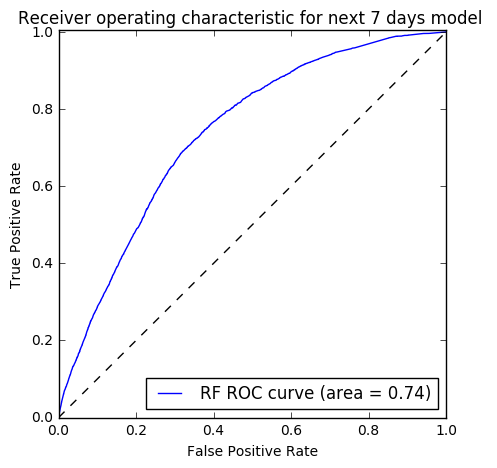

In [78]:
# Plot ROC in one graph
y_rf_score = rf_7.predict_proba(df_val_X7)[:, 1]
fpr_rf, tpr_rf, _rf = roc_curve(df_val_Y7, y_rf_score)
roc_rf_auc = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(5, 5))
plt.plot(fpr_rf, tpr_rf, label='RF ROC curve (area = %0.2f)' % roc_rf_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for next 7 days model ')
plt.legend(loc="lower right")
plt.show()

### Feature Importance 

Feature importance of Random Forest Model


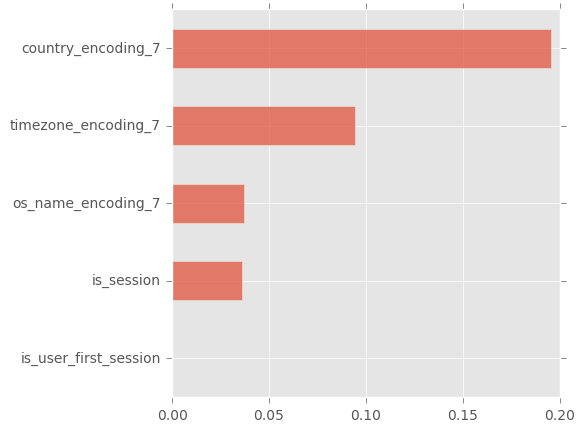

In [89]:
 
# Check feature importance and display in bar plot.
print('Feature importance of Random Forest Model')
plt.style.use('ggplot')
fig = plt.figure(figsize=(5, 5))
feat_importances = pd.Series(rf_7.feature_importances_, index=df_train_X7.columns)
feat_importances.nsmallest(5).plot(kind='barh', alpha=0.7)
plt.show()

## Random Forest Model for next 14 days

In [90]:
rf_14 = RandomForestClassifier(n_estimators=100,  max_depth =5, max_features = 'sqrt', max_leaf_nodes= 8).fit(df_train_X14, df_train_Y14)
y_pred = rf_14.predict(df_val_X14) 
print(classification_report(df_val_Y14,y_pred))  
print("The accuracy for the model is ")
print(accuracy_score(df_val_Y14,y_pred))

             precision    recall  f1-score   support

          0       0.92      1.00      0.96     60254
          1       0.00      0.00      0.00      5571

avg / total       0.84      0.92      0.87     65825

The accuracy for the model is 
0.915366502089


### ROC

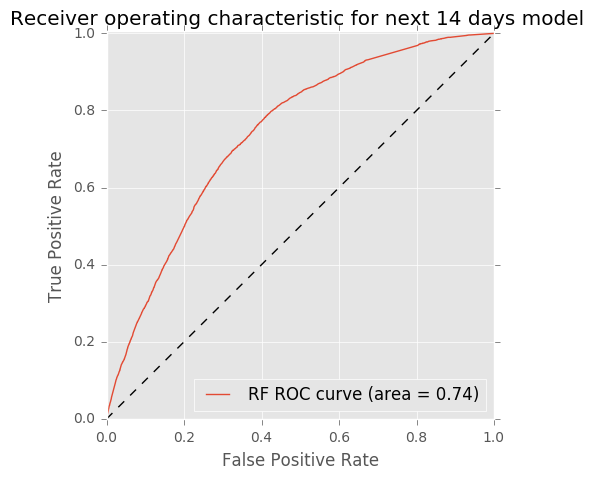

In [91]:
# Plot ROC in one graph
y_rf_score = rf_14.predict_proba(df_val_X14)[:, 1]
fpr_rf, tpr_rf, _rf = roc_curve(df_val_Y14, y_rf_score)
roc_rf_auc = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(5, 5))
plt.plot(fpr_rf, tpr_rf, label='RF ROC curve (area = %0.2f)' % roc_rf_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for next 14 days model ')
plt.legend(loc="lower right")
plt.show()
fig.savefig('roc_rf14_auc.png')

###  Feature Importance 

Feature importance of Random Forest Model


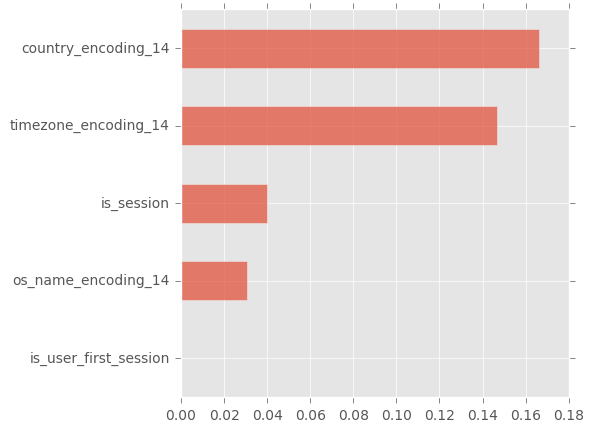

In [92]:

# Check feature importance and display in bar plot.
print('Feature importance of Random Forest Model')
plt.style.use('ggplot')
fig = plt.figure(figsize=(5, 5))
feat_importances = pd.Series(rf_14.feature_importances_, index=df_train_X14.columns)
feat_importances.nsmallest(5).plot(kind='barh', alpha=0.7)
plt.show()

## Prediction for the test dataset 

Combine training and validation data together to predict the test dataset

In [108]:
frames = [df_train_X7,df_val_X7]
train_X7 = pd.concat(frames)
frames = [df_train_X14,df_val_X14]
train_X14 = pd.concat(frames)
frames = [df_train_Y7,df_val_Y7]
train_Y7 = pd.concat(frames)
frames = [df_train_Y14,df_val_Y14]
train_Y14 = pd.concat(frames)

Fit Random forest model based on the whole dataset 

In [116]:
rf_7_test = RandomForestClassifier(n_estimators=100,  max_depth =5, max_features = 'sqrt', max_leaf_nodes= 8).fit(train_X7, train_Y7)
rf_7_prob = rf_7_test.predict_proba(df_test_X7) 
rf_14_test = RandomForestClassifier(n_estimators=100,  max_depth =5, max_features = 'sqrt', max_leaf_nodes= 8).fit(train_X14, train_Y14)
rf_14_prob = rf_14_test.predict_proba(df_test_X14) 

In [133]:
df = pd.DataFrame({'user_id_hash': df_test.user_id_hash,
                   'user_purchase_binary_7_days': list(rf_7_prob[:, 1]),
                   'user_purchase_binary_14_days': list(rf_14_prob[:,1])})

In [134]:
df.head()

,user_id_hash,user_purchase_binary_14_days,user_purchase_binary_7_days
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,0.128928,0.099815
1,000059859ec188af6035870faf885c3038cedda05b3a54...,0.100481,0.086370
2,000062e9be78f3da274fec338e78f89d12000e781967f2...,0.158572,0.128011
3,00006ad44c0d33a2a526caf75514643639b7b7070dfffd...,0.038806,0.034922
4,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,0.047371,0.033722


In [135]:
df.to_csv('prediction.csv', encoding='utf-8', index=False)

# Prediction Submission File

In [ ]:
df1 =  pd.read_csv('prediction.csv') ## Load our prediction file 
df2 =  pd.read_csv('sample_submission_2.csv') ## Load the sample prediction file 

In [ ]:
user = list(df2.user_id_hash.values) # Extract user id from the sample prediction file 
miss_users = list(set(user)- set(df.user_id_hash.values)) # Find the missing values in user id in our prediction file


In [ ]:
df = df1.loc[df1['user_id_hash'].isin(user)] ## Extract the prediction file with user id in user
df_miss =df2.loc[df2['user_id_hash'].isin(miss_users)] ## replace the missing values with the values in sample submissions


In [ ]:
prediction_submission = pd.concat([df,df_miss],sort =False) # concanate two dataframe together 
prediction_submission  = prediction_submission .to_csv('prediction.csv', index=False) # save to csv